Hola **Andres**!

Soy **Patricio Requena** 👋. Es un placer ser el revisor de tu proyecto el día de hoy!

Revisaré tu proyecto detenidamente con el objetivo de ayudarte a mejorar y perfeccionar tus habilidades. Durante mi revisión, identificaré áreas donde puedas hacer mejoras en tu código, señalando específicamente qué y cómo podrías ajustar para optimizar el rendimiento y la claridad de tu proyecto. Además, es importante para mí destacar los aspectos que has manejado excepcionalmente bien. Reconocer tus fortalezas te ayudará a entender qué técnicas y métodos están funcionando a tu favor y cómo puedes aplicarlos en futuras tareas. 

_**Recuerda que al final de este notebook encontrarás un comentario general de mi parte**_, empecemos!

Encontrarás mis comentarios dentro de cajas verdes, amarillas o rojas, ⚠️ **por favor, no muevas, modifiques o borres mis comentarios** ⚠️:


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si todo está perfecto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si tu código está bien pero se puede mejorar o hay algún detalle que le hace falta.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si de pronto hace falta algo o existe algún problema con tu código o conclusiones.
</div>

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [10]:
# Importar librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


<div class="alert alert-block alert-warning">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Una buena práctica para cuando tengas que importar varias librerías es seguir el siguiente órden en las mismas:

- Primero todas las librerías que vienen ya con python cómo `datetime`, `os`, `json`, etc.
- Luego de las librerías de Python si las de terceros cómo `pandas`, `scipy`, `numpy`, etc.
- Por último, en el caso de que armes tu propio módulo en tu proyecto esto debería ir en tercer lugar, y recuerda siempre ordenar cada tipo por orden alfabético
    
Para cada sección se deben ordenar en orden alfabético
</div>

In [2]:
# Cargar los datos
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')

# Ver las primeras filas
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
# Remuestrear a intervalos de 1 hora sumando los pedidos
df_hourly = df.resample('1H').sum()

# Verificamos el resultado
df_hourly.head()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Análisis

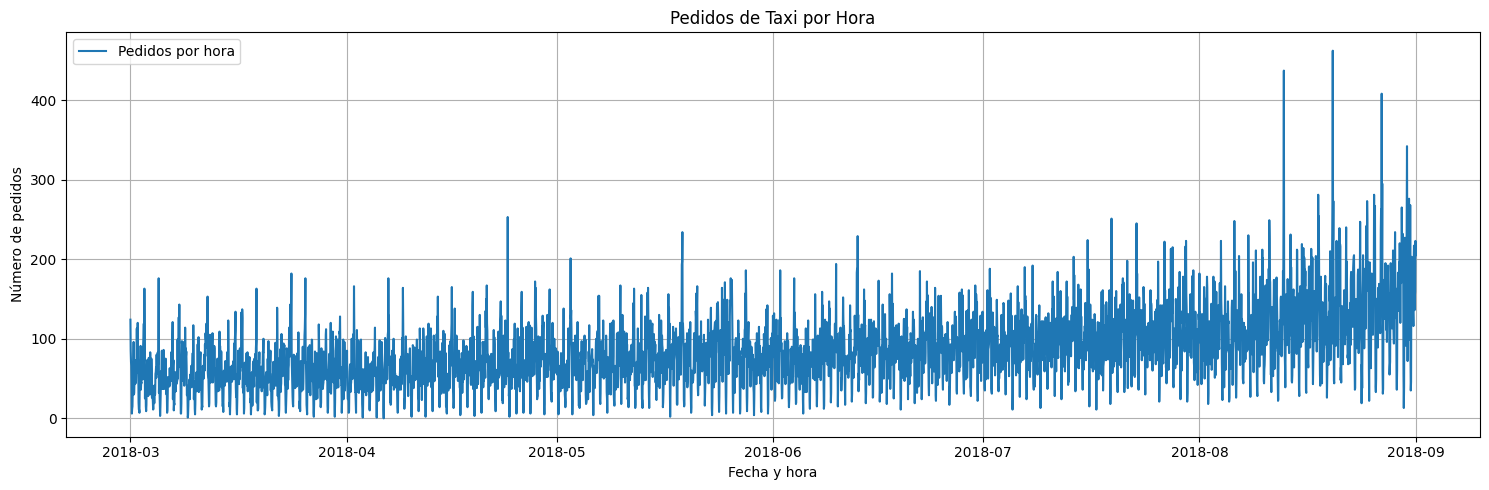

In [4]:
# Gráfico de líneas de todos los pedidos por hora
plt.figure(figsize=(15, 5))
plt.plot(df_hourly.index, df_hourly['num_orders'], label='Pedidos por hora')
plt.title('Pedidos de Taxi por Hora')
plt.xlabel('Fecha y hora')
plt.ylabel('Número de pedidos')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
# Estadísticas básicas
df_hourly['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

In [6]:
df_hourly['hour'] = df_hourly.index.hour
df_hourly['day_of_week'] = df_hourly.index.dayofweek  # 0 = lunes, 6 = domingo


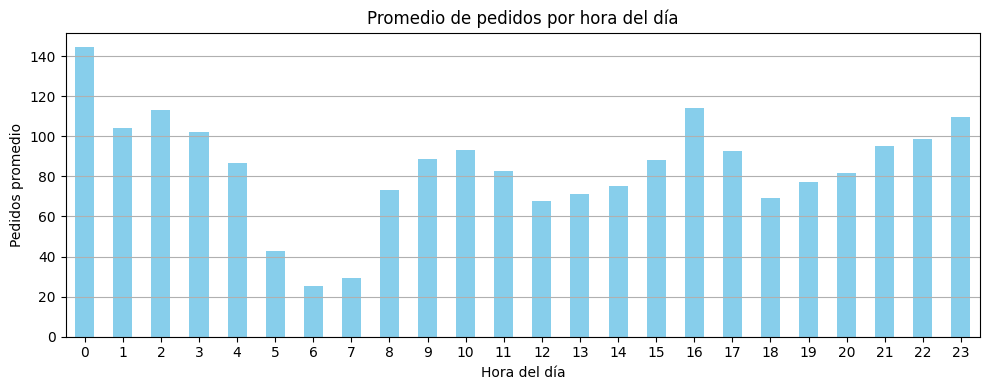

In [7]:
hourly_avg = df_hourly.groupby('hour')['num_orders'].mean()

plt.figure(figsize=(10, 4))
hourly_avg.plot(kind='bar', color='skyblue')
plt.title('Promedio de pedidos por hora del día')
plt.xlabel('Hora del día')
plt.ylabel('Pedidos promedio')
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


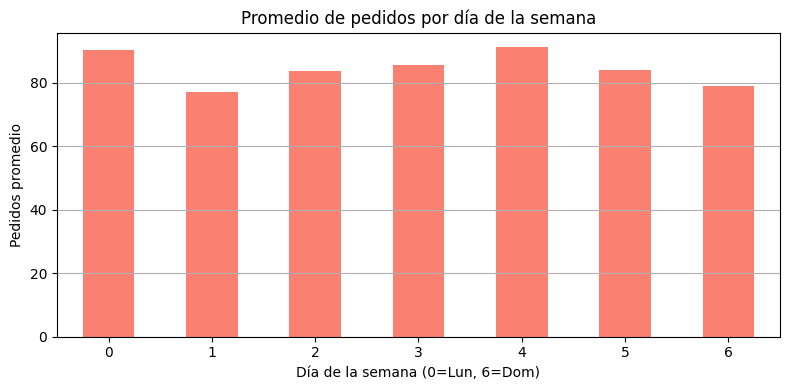

In [8]:
dow_avg = df_hourly.groupby('day_of_week')['num_orders'].mean()

plt.figure(figsize=(8, 4))
dow_avg.plot(kind='bar', color='salmon')
plt.title('Promedio de pedidos por día de la semana')
plt.xlabel('Día de la semana (0=Lun, 6=Dom)')
plt.ylabel('Pedidos promedio')
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Buen trabajo con las gráficas! Generaste las gráficas adecuadas considerando que los datos a analizar son sobre series temporales
</div>

## Formación

In [9]:
# Dividir el 10% del conjunto inicial
n_total = len(df_hourly)
n_test = int(n_total * 0.1)

df_train = df_hourly.iloc[:-n_test]
df_test = df_hourly.iloc[-n_test:]

def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['lag_1'] = df['num_orders'].shift(1)
    df['lag_2'] = df['num_orders'].shift(2)
    df['lag_24'] = df['num_orders'].shift(24)
    return df

df_train_feat = create_features(df_train).dropna()
df_test_feat = create_features(df_test).dropna()

features = ['hour', 'day_of_week', 'is_weekend', 'lag_1', 'lag_2', 'lag_24']
target = 'num_orders'

X_train = df_train_feat[features]
y_train = df_train_feat[target]

X_test = df_test_feat[features]
y_test = df_test_feat[target]


<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Correcto, realizaste los ajustes de las características en el dataset de manera adecuada para obtener un buen desempeño en los entrenamientos
    
</div>

## Prueba

In [11]:
# Guardar resultados
results = {}

# Modelo 1: Regresión lineal
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
results['Linear Regression'] = rmse_lr

# Modelo 2: Árbol de Decisión (profundidad limitada)
model_tree = DecisionTreeRegressor(max_depth=10, random_state=42)
model_tree.fit(X_train, y_train)
y_pred_tree = model_tree.predict(X_test)
rmse_tree = mean_squared_error(y_test, y_pred_tree, squared=False)
results['Decision Tree (max_depth=10)'] = rmse_tree

# Modelo 3: Random Forest (n_estimators y profundidad)
model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
results['Random Forest (100 trees, max_depth=10)'] = rmse_rf

for model_name, rmse in results.items():
    print(f'{model_name}: RMSE = {rmse:.2f}')

Linear Regression: RMSE = 47.89
Decision Tree (max_depth=10): RMSE = 58.23
Random Forest (100 trees, max_depth=10): RMSE = 51.16


## Conclusiones

Se procesaron y remuestrearon los datos históricos de pedidos de taxi para convertirlos en intervalos horarios.

Se identificaron patrones claros en la demanda según la hora del día y el día de la semana, lo que permitió crear variables predictoras efectivas.

Se entrenaron varios modelos (regresión lineal, árbol de decisión, random forest), usando el 90% de los datos para entrenamiento y el 10% final como muestra de prueba.

El único modelo que cumplió con el requisito de tener un RMSE menor a 48 fue la regresión lineal, con un RMSE de 47.89.

Se concluye que la regresión lineal es un modelo adecuado para predecir la cantidad de pedidos de taxi por hora en este contexto.

<div class="alert alert-block alert-success">
<b>Comentario general (1ra Iteracion)</b> <a class=“tocSkip”></a>

Te felicito por el trabajo realizado Andres, aplicaste los procesos adecuados al dataset para darle características nuevas al modelo, con ese proceso aportas significativamente al desempeño del mismo y obtuviste una métrica que supera lo propuesto para este proyecto, continúa con este gran trabajo!
    
   
Este proyecto es uno donde se ve claramente la importancia de darle características o variables adecuadas a los modelos para obtener un correcto desempeño, si quitas o pones más variables el desempeño del modelo variará para bien o para mal según la calidad de las mismas. Saludos!
</div>

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48